# Figure: synthetic data

In [1]:
%load_ext autoreload 
%autoreload 2
from utils.prediction_models import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

## Parameter space

In [4]:
ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']

n_traits=100
min_zeros_ratio, min_ones_ratio=0.1,0.1

parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append((n_samples,n_total_features,n_true_features, min_split_ratio))

# Generate synthetic data

In [5]:
# Generate simulated data

DIR_synthetic_data=f"{DIR_data}/figure_data/4B/synthetic_data"

for n_samples, n_total_features, n_true_features,min_split_ratio in tqdm(parameter_space,desc="Generating simulated data"):

    ff_out=os.path.join(DIR_synthetic_data,f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}.pk")
    if os.path.exists(ff_out):
        print("File exists, skipping")
        continue

    X=bacdive['ko_data'].copy()

    # Subsample X  
    if n_samples is not None and n_samples < X.shape[0]:
        samples=np.random.choice(X.index.values, n_samples, replace=False)
        X=X.loc[samples,:]

    if n_total_features is not None and n_total_features < X.shape[1]:
        features=np.random.choice(X.columns.values, n_total_features, replace=False)
        X=X[features]


    # Generate y
    y={}
    mechanism={}
    for i in range(n_traits):
        while True:
            logic_tree=BinaryLogicTree()
            true_features=np.random.choice(X.columns.values, n_true_features, replace=False)
            logic_tree.random_populate(true_features,min_split_ratio=min_split_ratio, p_and=None)
            traits=X.apply(logic_tree.calculate, axis=1).astype(int)

            if traits.mean()>=min_ones_ratio and traits.mean()<=(1-min_zeros_ratio):
                break
        y[f'sim_trait_{i}']=traits
        mechanism[f'sim_trait_{i}']={"logic_object":logic_tree, "logic_str":str(logic_tree),"true_features":true_features}

    y=pd.DataFrame(y)
    mechanism=pd.DataFrame(mechanism).T
    synthetic_data=finalize_data(X,y,tree,remove_prefix=False)
    synthetic_data['mechanism']=mechanism

    with open(ff_out,'wb') as f:
        pickle.dump(synthetic_data,f)

Generating simulated data: 100%|██████████| 240/240 [00:00<00:00, 8309.53it/s]

File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exists, skipping
File exist

# Run models

In [6]:
threads=48 
# p=Pool(threads)

In [7]:
DIR_figure=f"{DIR_data}/figure_data/4B"


models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
}

matrices={'_'.join(params):pd.read_pickle(f"/home/zeqianli/project/zeqian/Carbon/data/figure_data/4B/synthetic_data/{'_'.join(params).pk}") for params in parameter_space}


TypeError: sequence item 0: expected str instance, int found

In [ ]:
ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']

n_traits=100
min_zeros_ratio, min_ones_ratio=0.1,0.1

parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append((n_samples,n_total_features,n_true_features, min_split_ratio))

In [ ]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

# Plot phase diagram

In [7]:
threads=48

ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']
min_zeros_ratio, min_ones_ratio=0.1,0.1
parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100][::-1]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100][::-1]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append([n_samples,n_total_features,n_true_features, min_split_ratio])

# DIR_figure=f"{DIR_data}/figure_data/4B"
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data_publishing/figure_data/4B"

models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False,
                'multithreading_batch': threads
                }],
}


In [8]:
def load_results(model_names,keys=['carbon_name','accuracy']):
    results_all=[]
    for params in tqdm(parameter_space):
        n_samples, n_total_features,n_true_features,min_split_ratio = params
        param_str='_'.join([str(p) for p in params])
        for model_name in models.keys(): 
            if not model_name in model_names:
                continue       
            ff_results=os.path.join(DIR_figure,'results',f"{param_str}_{model_name}.pk")
            try:
                results=pd.read_pickle(ff_results)
                if keys:
                    results=results[keys]
            except FileNotFoundError:
                print(f"{ff_results} not found. Skipping.")
                continue
            results['n_samples']=n_samples
            results['n_total_features']=n_total_features
            results['n_true_features']=n_true_features
            results['min_split_ratio']=min_split_ratio
            results['model']=model_name
            results_all.append(results)
    results_all=pd.concat(results_all,axis=0, ignore_index=True).astype({'n_true_features':str})
    return results_all

## RF OOC

In [7]:
rf_ooc=load_results(['RF_ooc'],keys=['carbon_name','accuracy','balanced_accuracy'])
rf_ooc=rf_ooc[rf_ooc['min_split_ratio']==0]

100%|██████████| 240/240 [00:34<00:00,  7.05it/s]


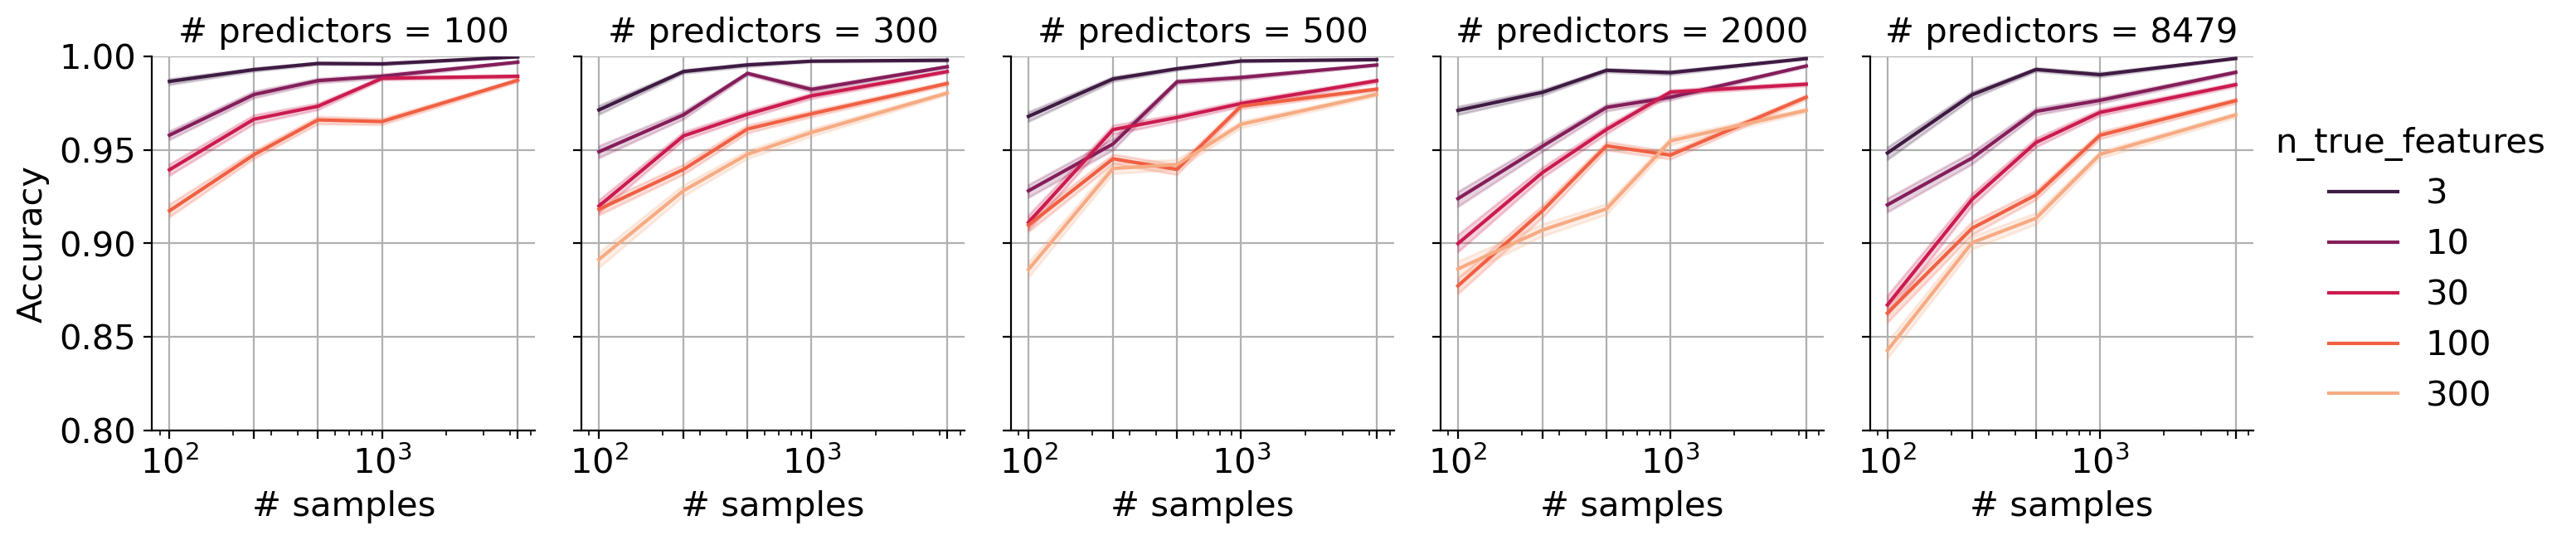

In [14]:
g=sns.relplot(data=rf_ooc,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )
g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0.8,1),xticks=df['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()

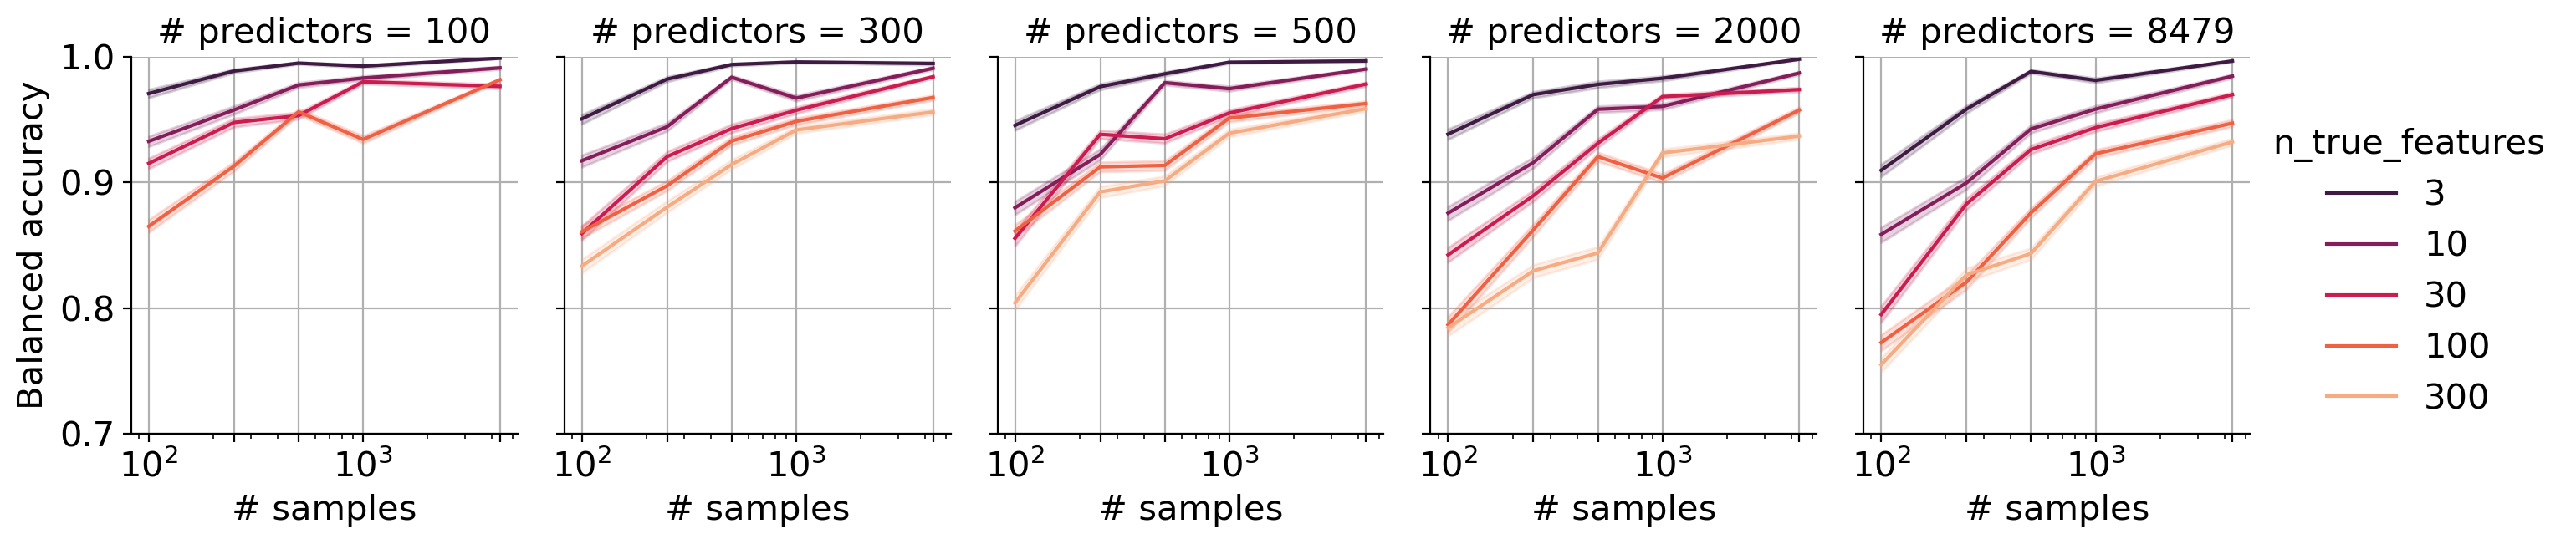

In [22]:
# Balanced accruacy
g=sns.relplot(data=rf_ooc,
    x='n_samples',y='balanced_accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )

g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Balanced accuracy')
g.set(xscale='log',ylim=(0.7,1),xticks=rf_ooc['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()

## Null

In [6]:
null=load_results(['null','null_ooc','identity_null','identity_null_ooc'])
null=null[null['min_split_ratio']==0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [05:51<00:00,  2.93s/it]


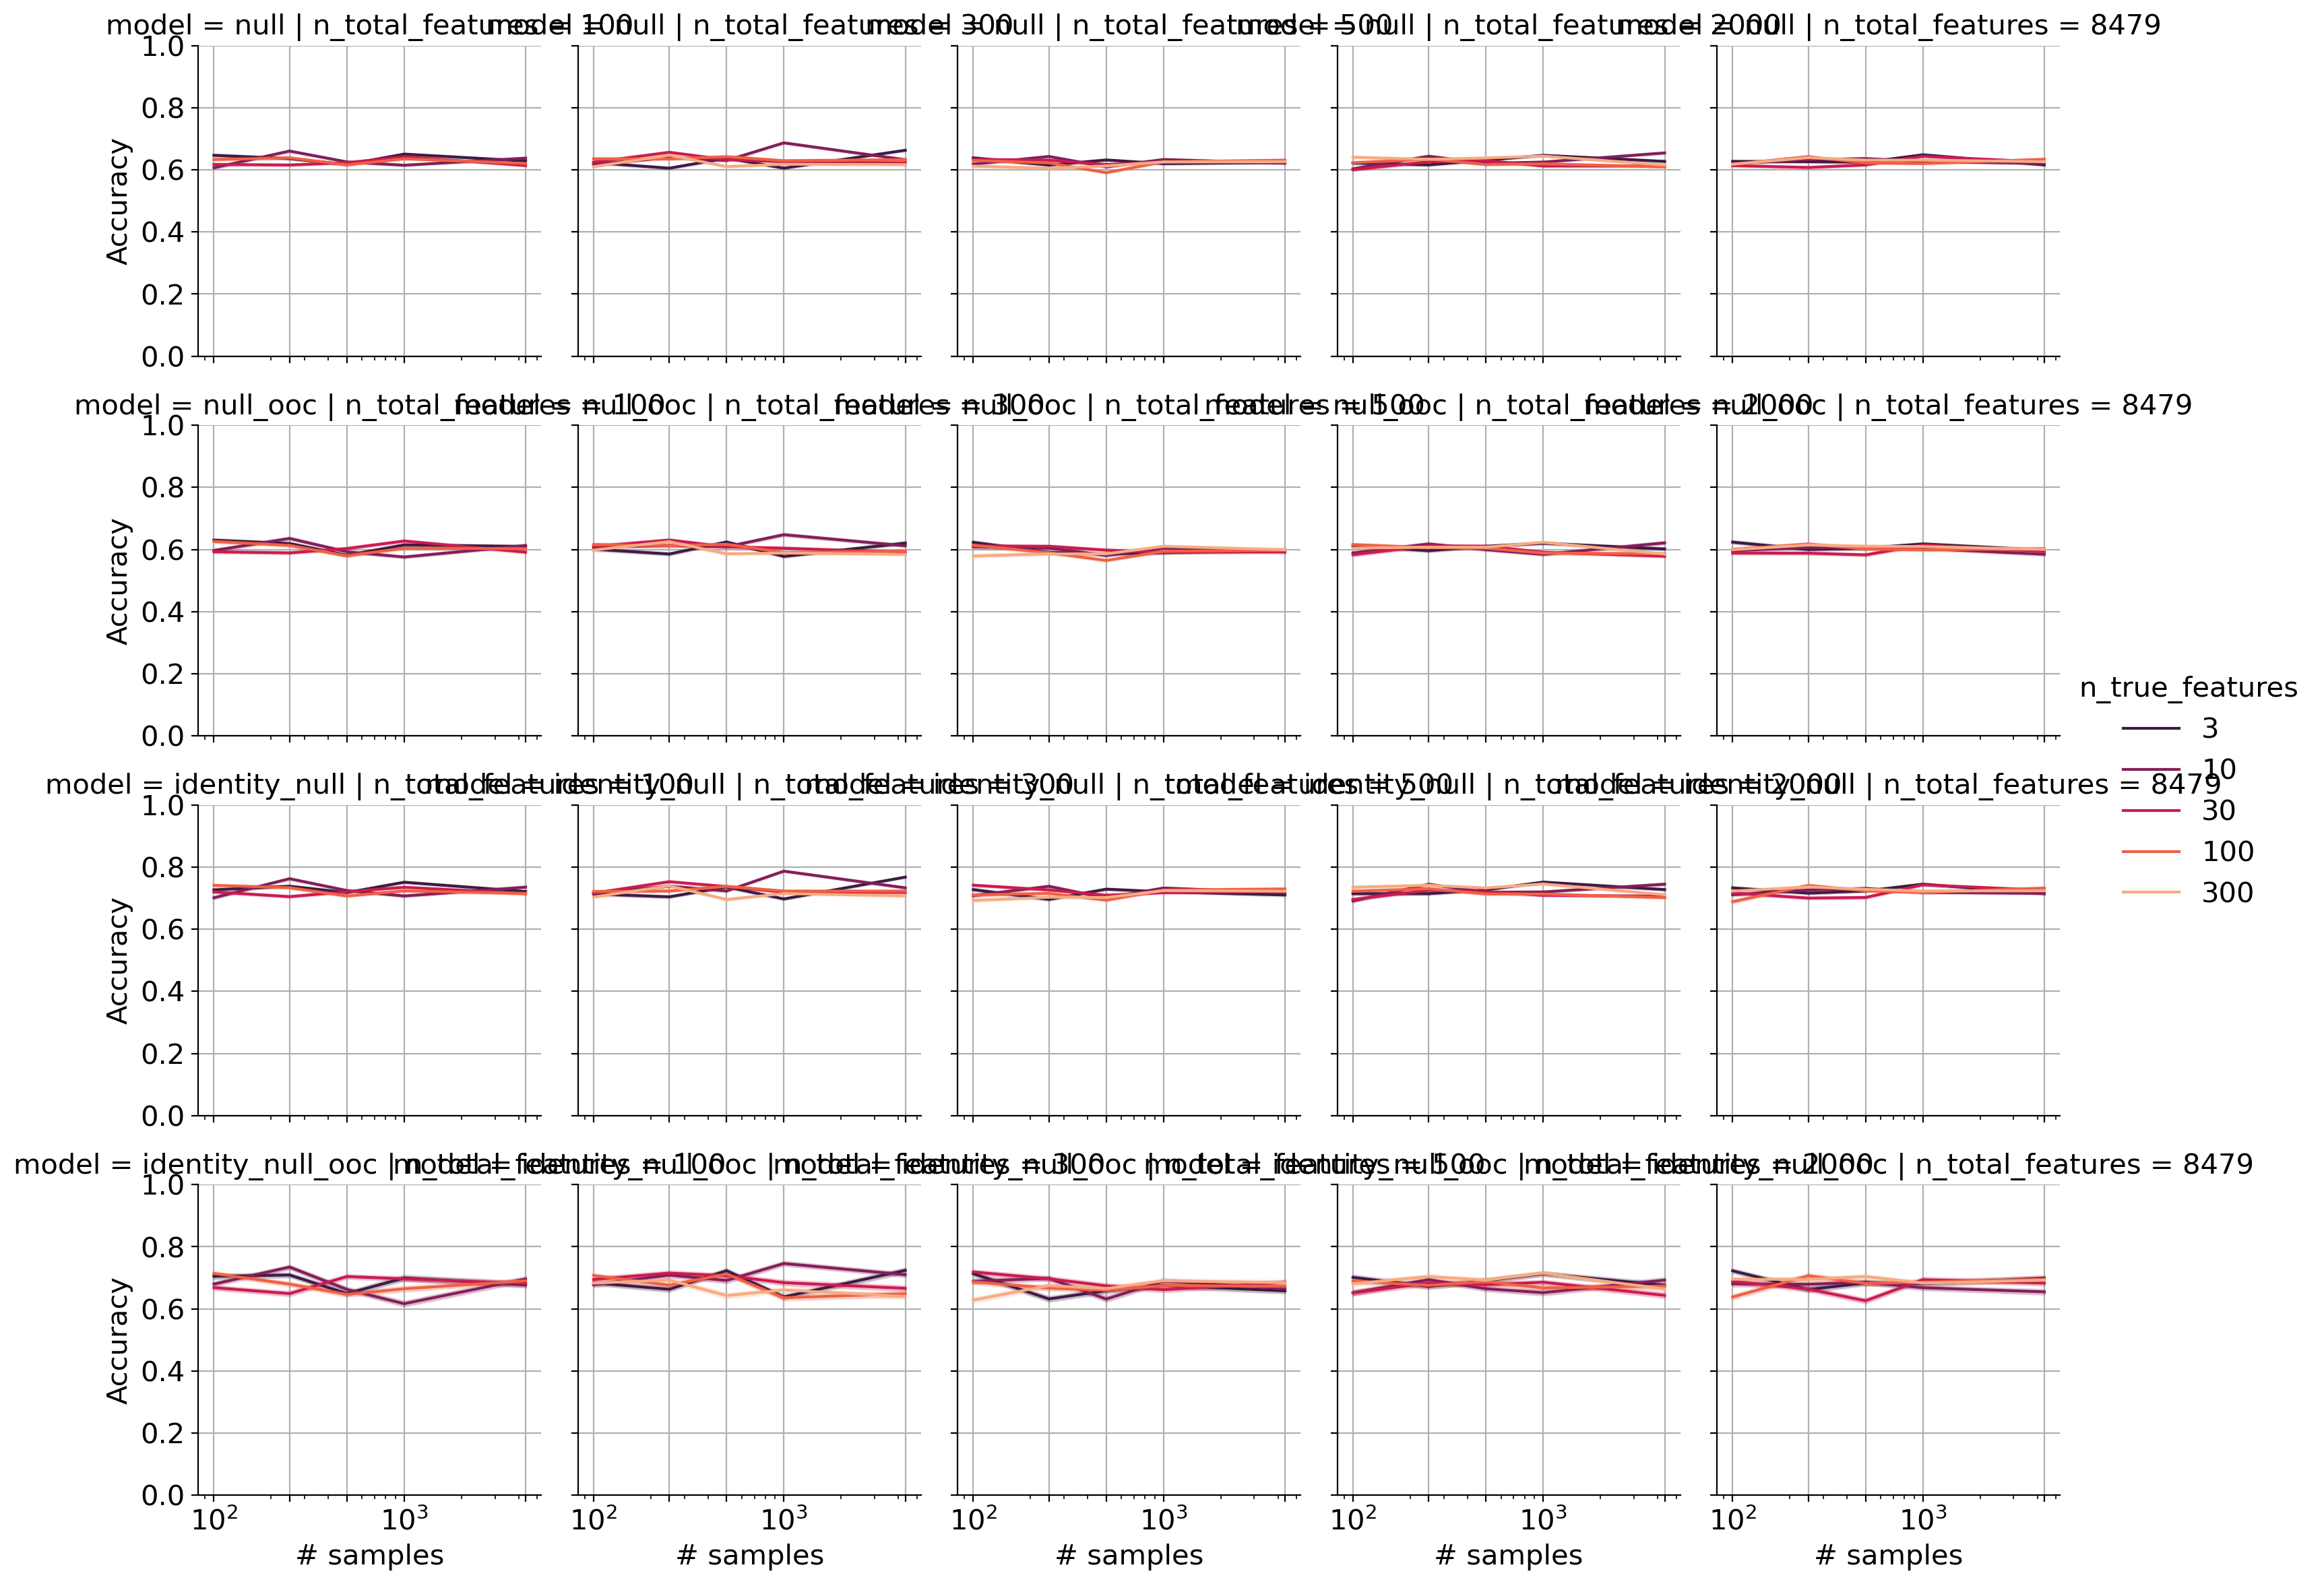

In [13]:
g=sns.relplot(data=null,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',row='model',
    height=3, aspect=1
    )

g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0,1),xticks=null['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()

## RF, random

In [14]:
rf=load_results(['RF'])
rf=rf[rf['min_split_ratio']==0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [01:29<00:00,  1.33it/s]


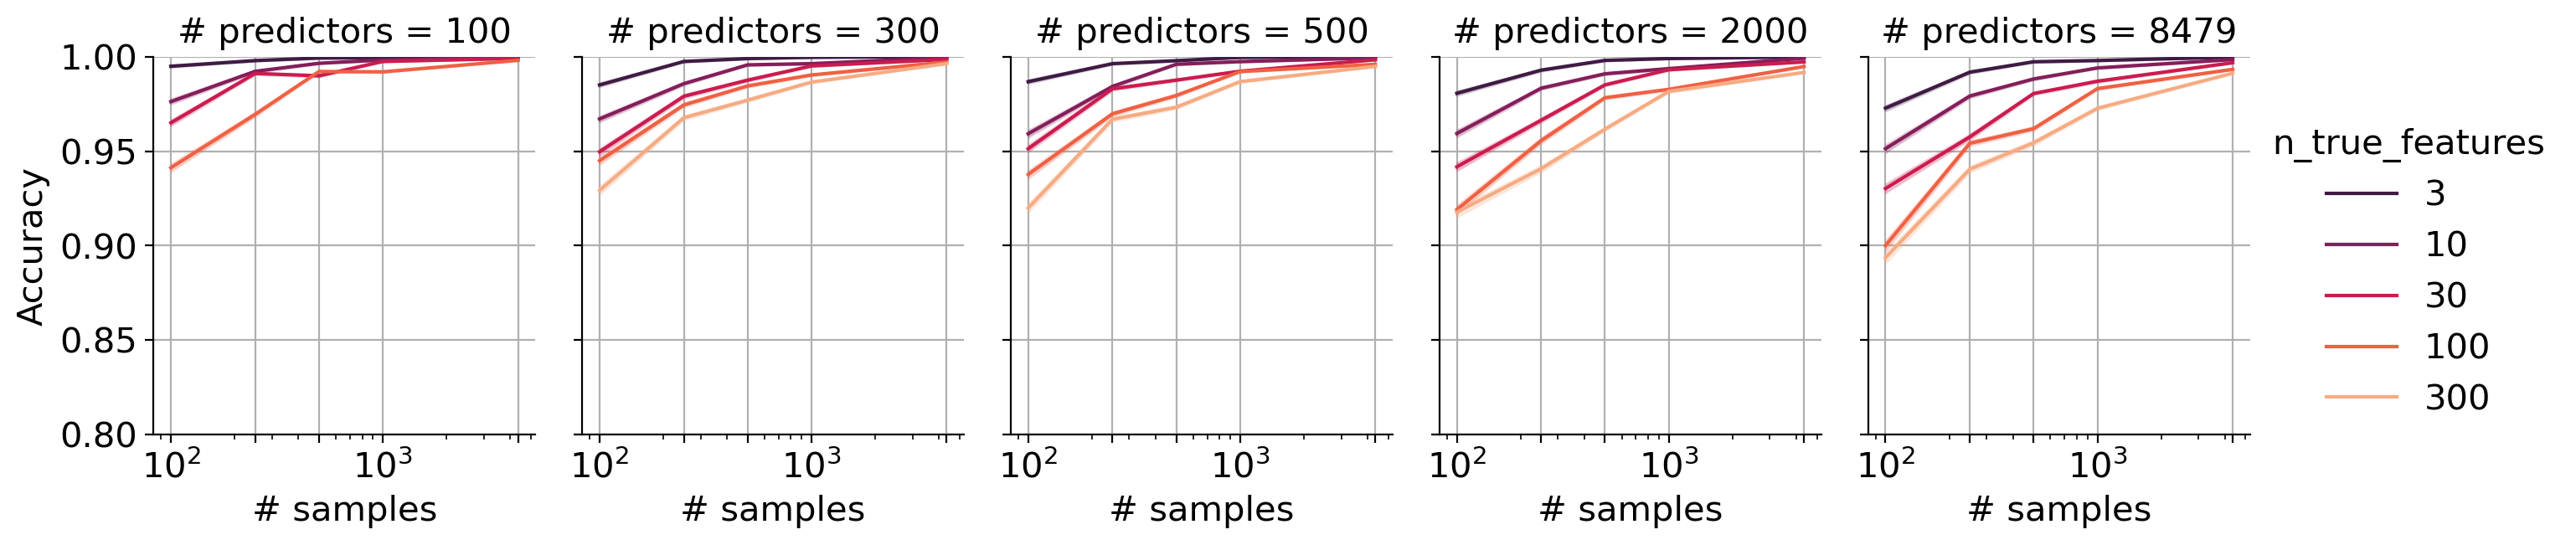

In [17]:
g=sns.relplot(data=rf,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )
g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0.8,1),xticks=rf['n_samples'].unique())


for ax in plt.gcf().get_axes():
    ax.grid()

## Modularity

### RF_ooc

In [9]:
rf_ooc=load_results(['RF_ooc'],keys=['carbon_name','accuracy','balanced_accuracy'])
rf_ooc=rf_ooc[rf_ooc['min_split_ratio']==0.3]

100%|██████████| 240/240 [00:35<00:00,  6.76it/s]


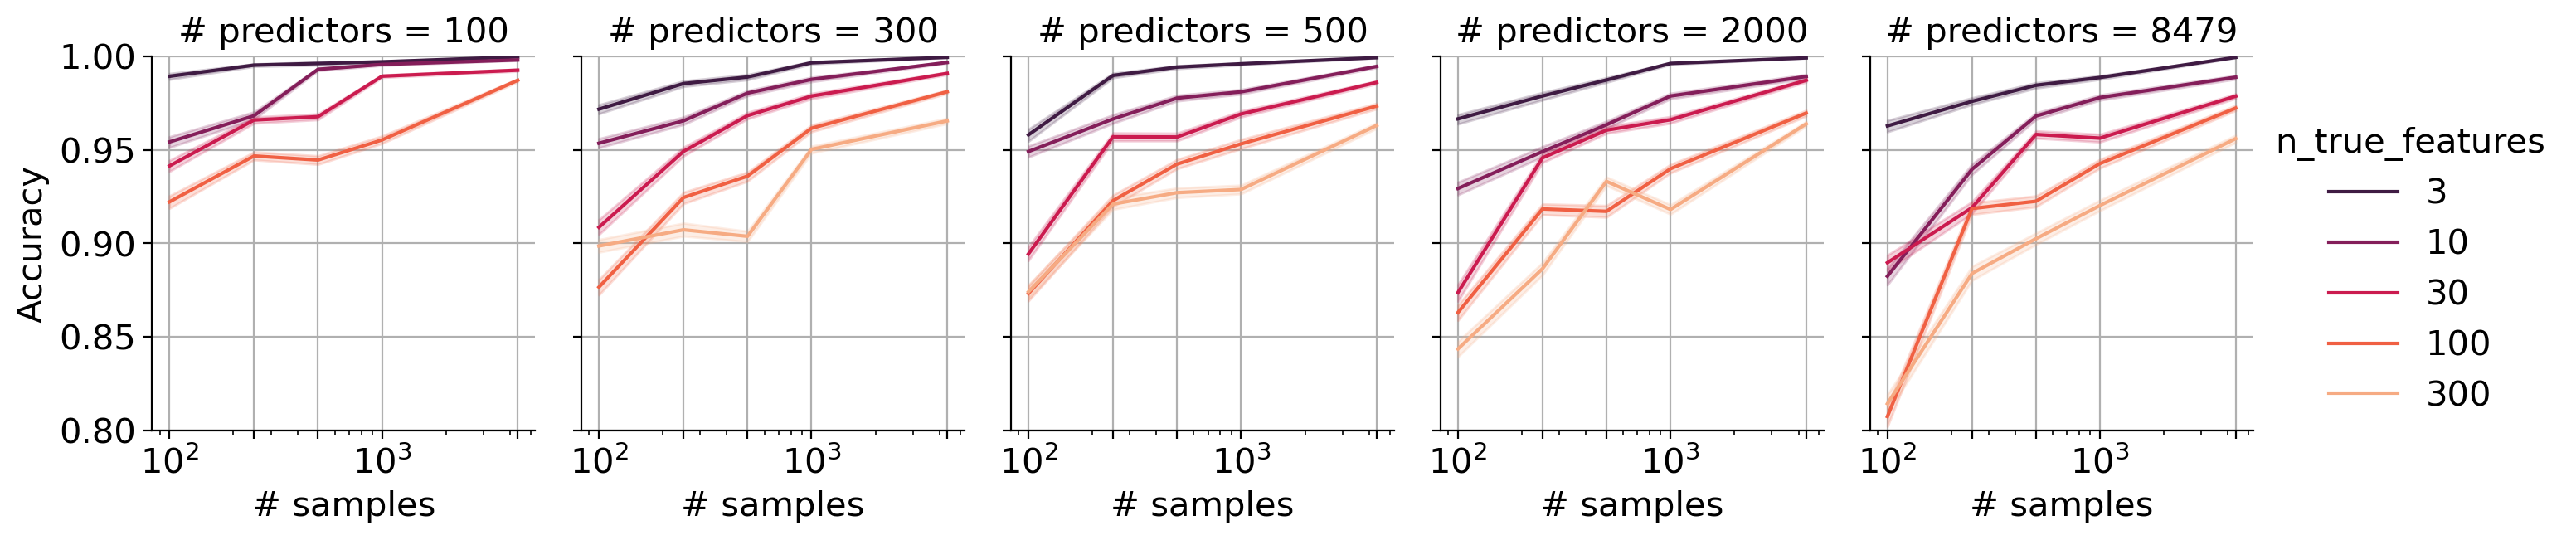

In [10]:
g=sns.relplot(data=rf_ooc,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features', kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )
g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0.8,1),xticks=rf_ooc['n_samples'].unique())

for ax in np.array(plt.gcf().get_axes()).flatten():
    ax.grid()

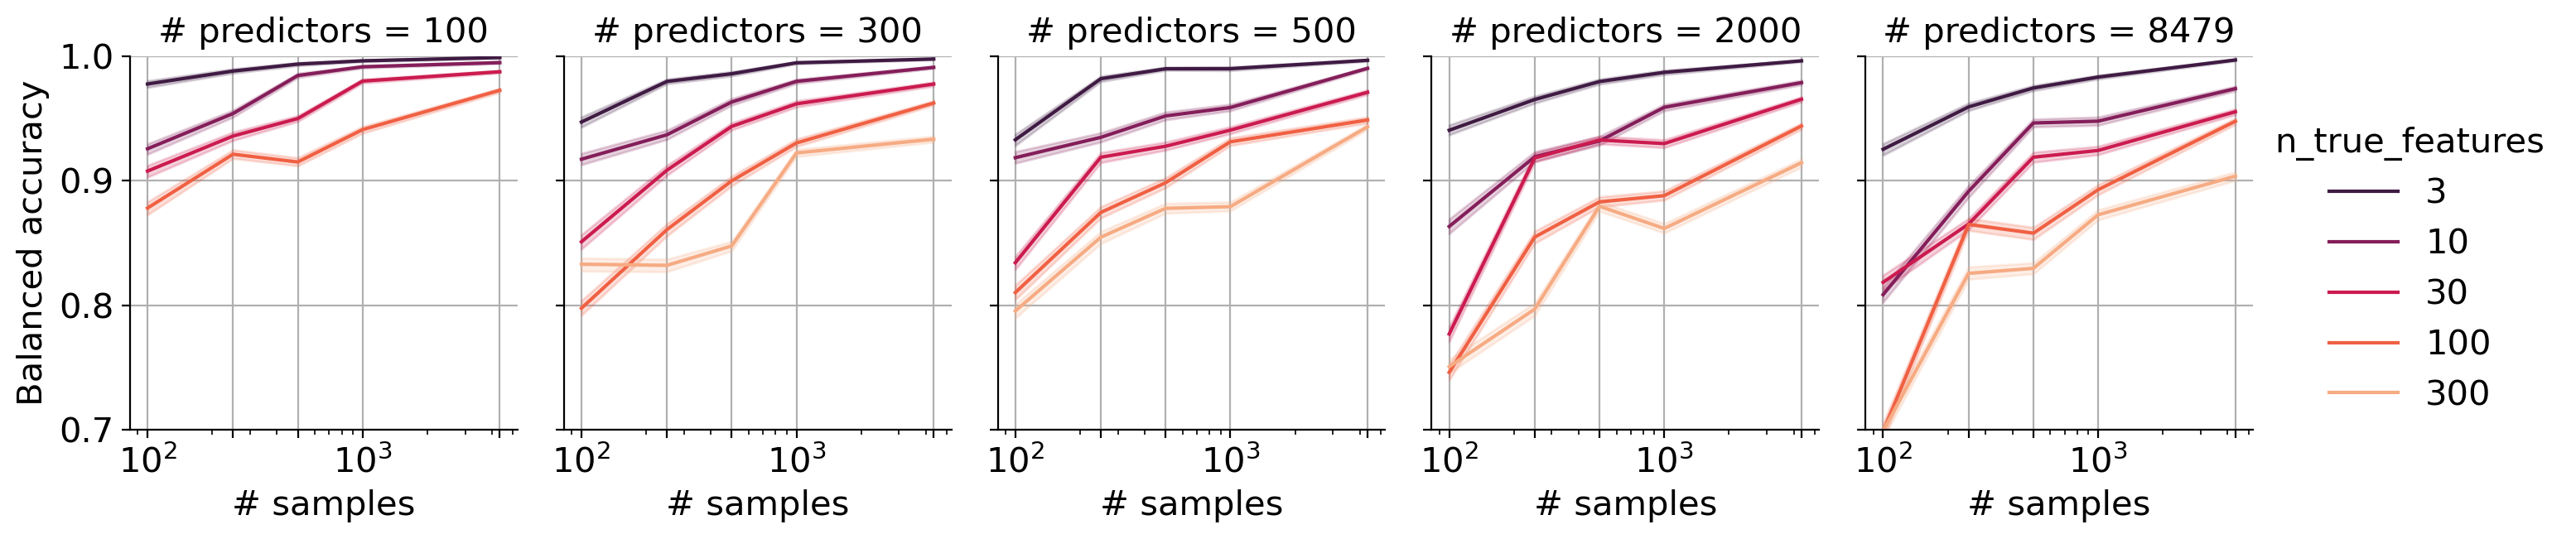

In [11]:
# Balanced accruacy
g=sns.relplot(data=rf_ooc,
    x='n_samples',y='balanced_accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )

g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Balanced accuracy')
g.set(xscale='log',ylim=(0.7,1),xticks=rf_ooc['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()

### RF

In [12]:
rf=load_results(['RF'])
rf=rf[rf['min_split_ratio']==0.3]

100%|██████████| 240/240 [00:46<00:00,  5.19it/s]


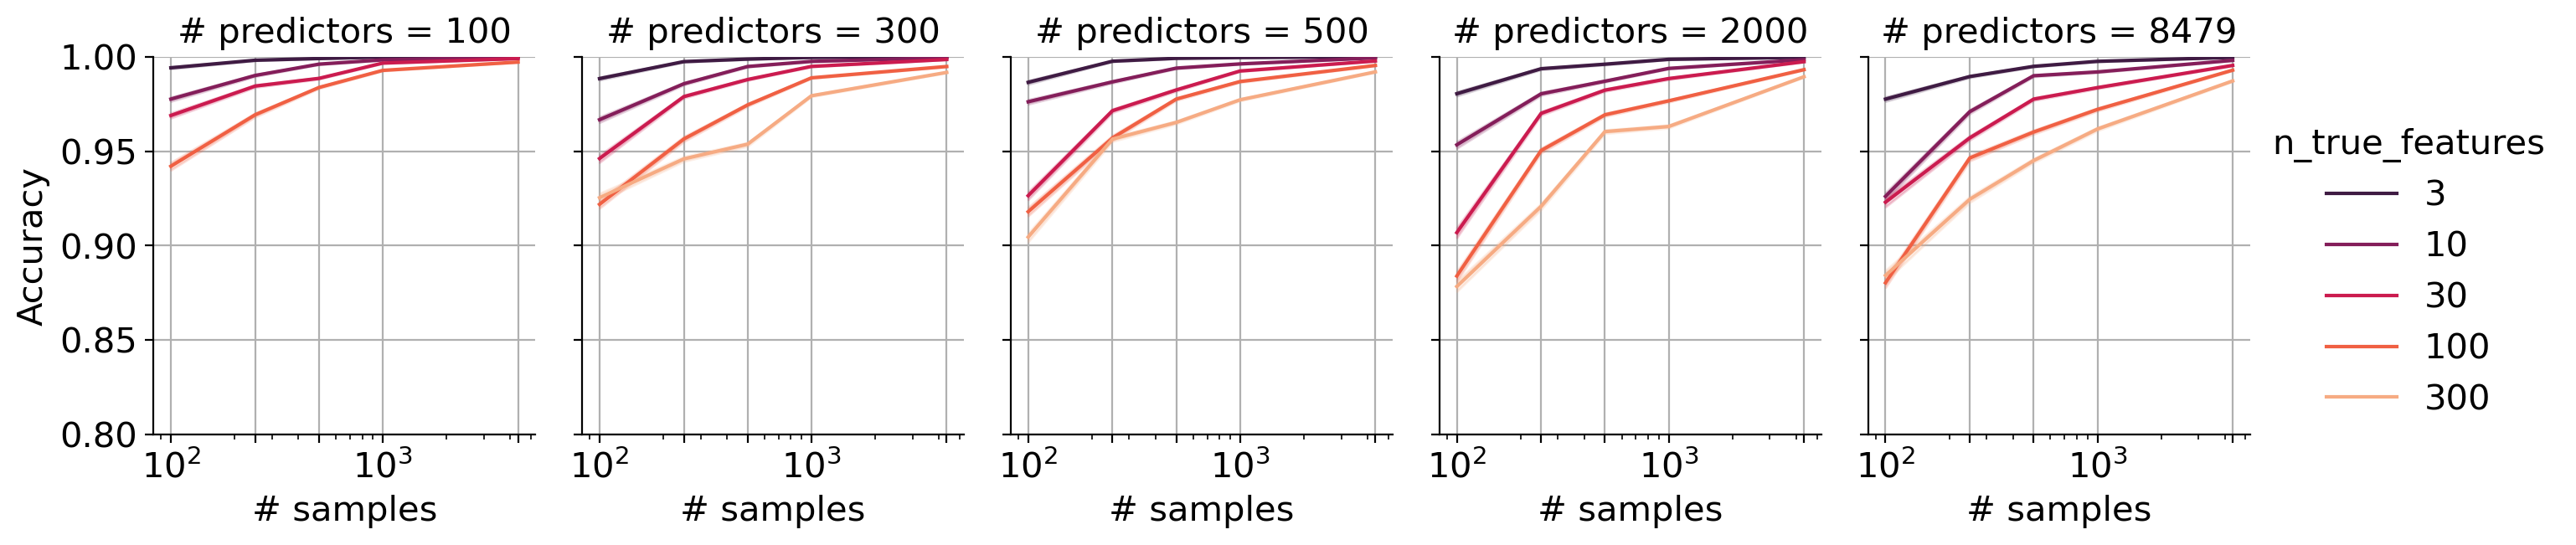

In [13]:
g=sns.relplot(data=rf,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=3.5, aspect=0.8
    )
g.set_titles(col_template='# predictors = {col_name}')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0.8,1),xticks=rf['n_samples'].unique())


for ax in np.array(plt.gcf().get_axes()).flatten():
    ax.grid()

### Null

In [14]:
null=load_results(['null','null_ooc','identity_null','identity_null_ooc'])
null=null[null['min_split_ratio']==0.3]

100%|██████████| 240/240 [02:49<00:00,  1.41it/s]


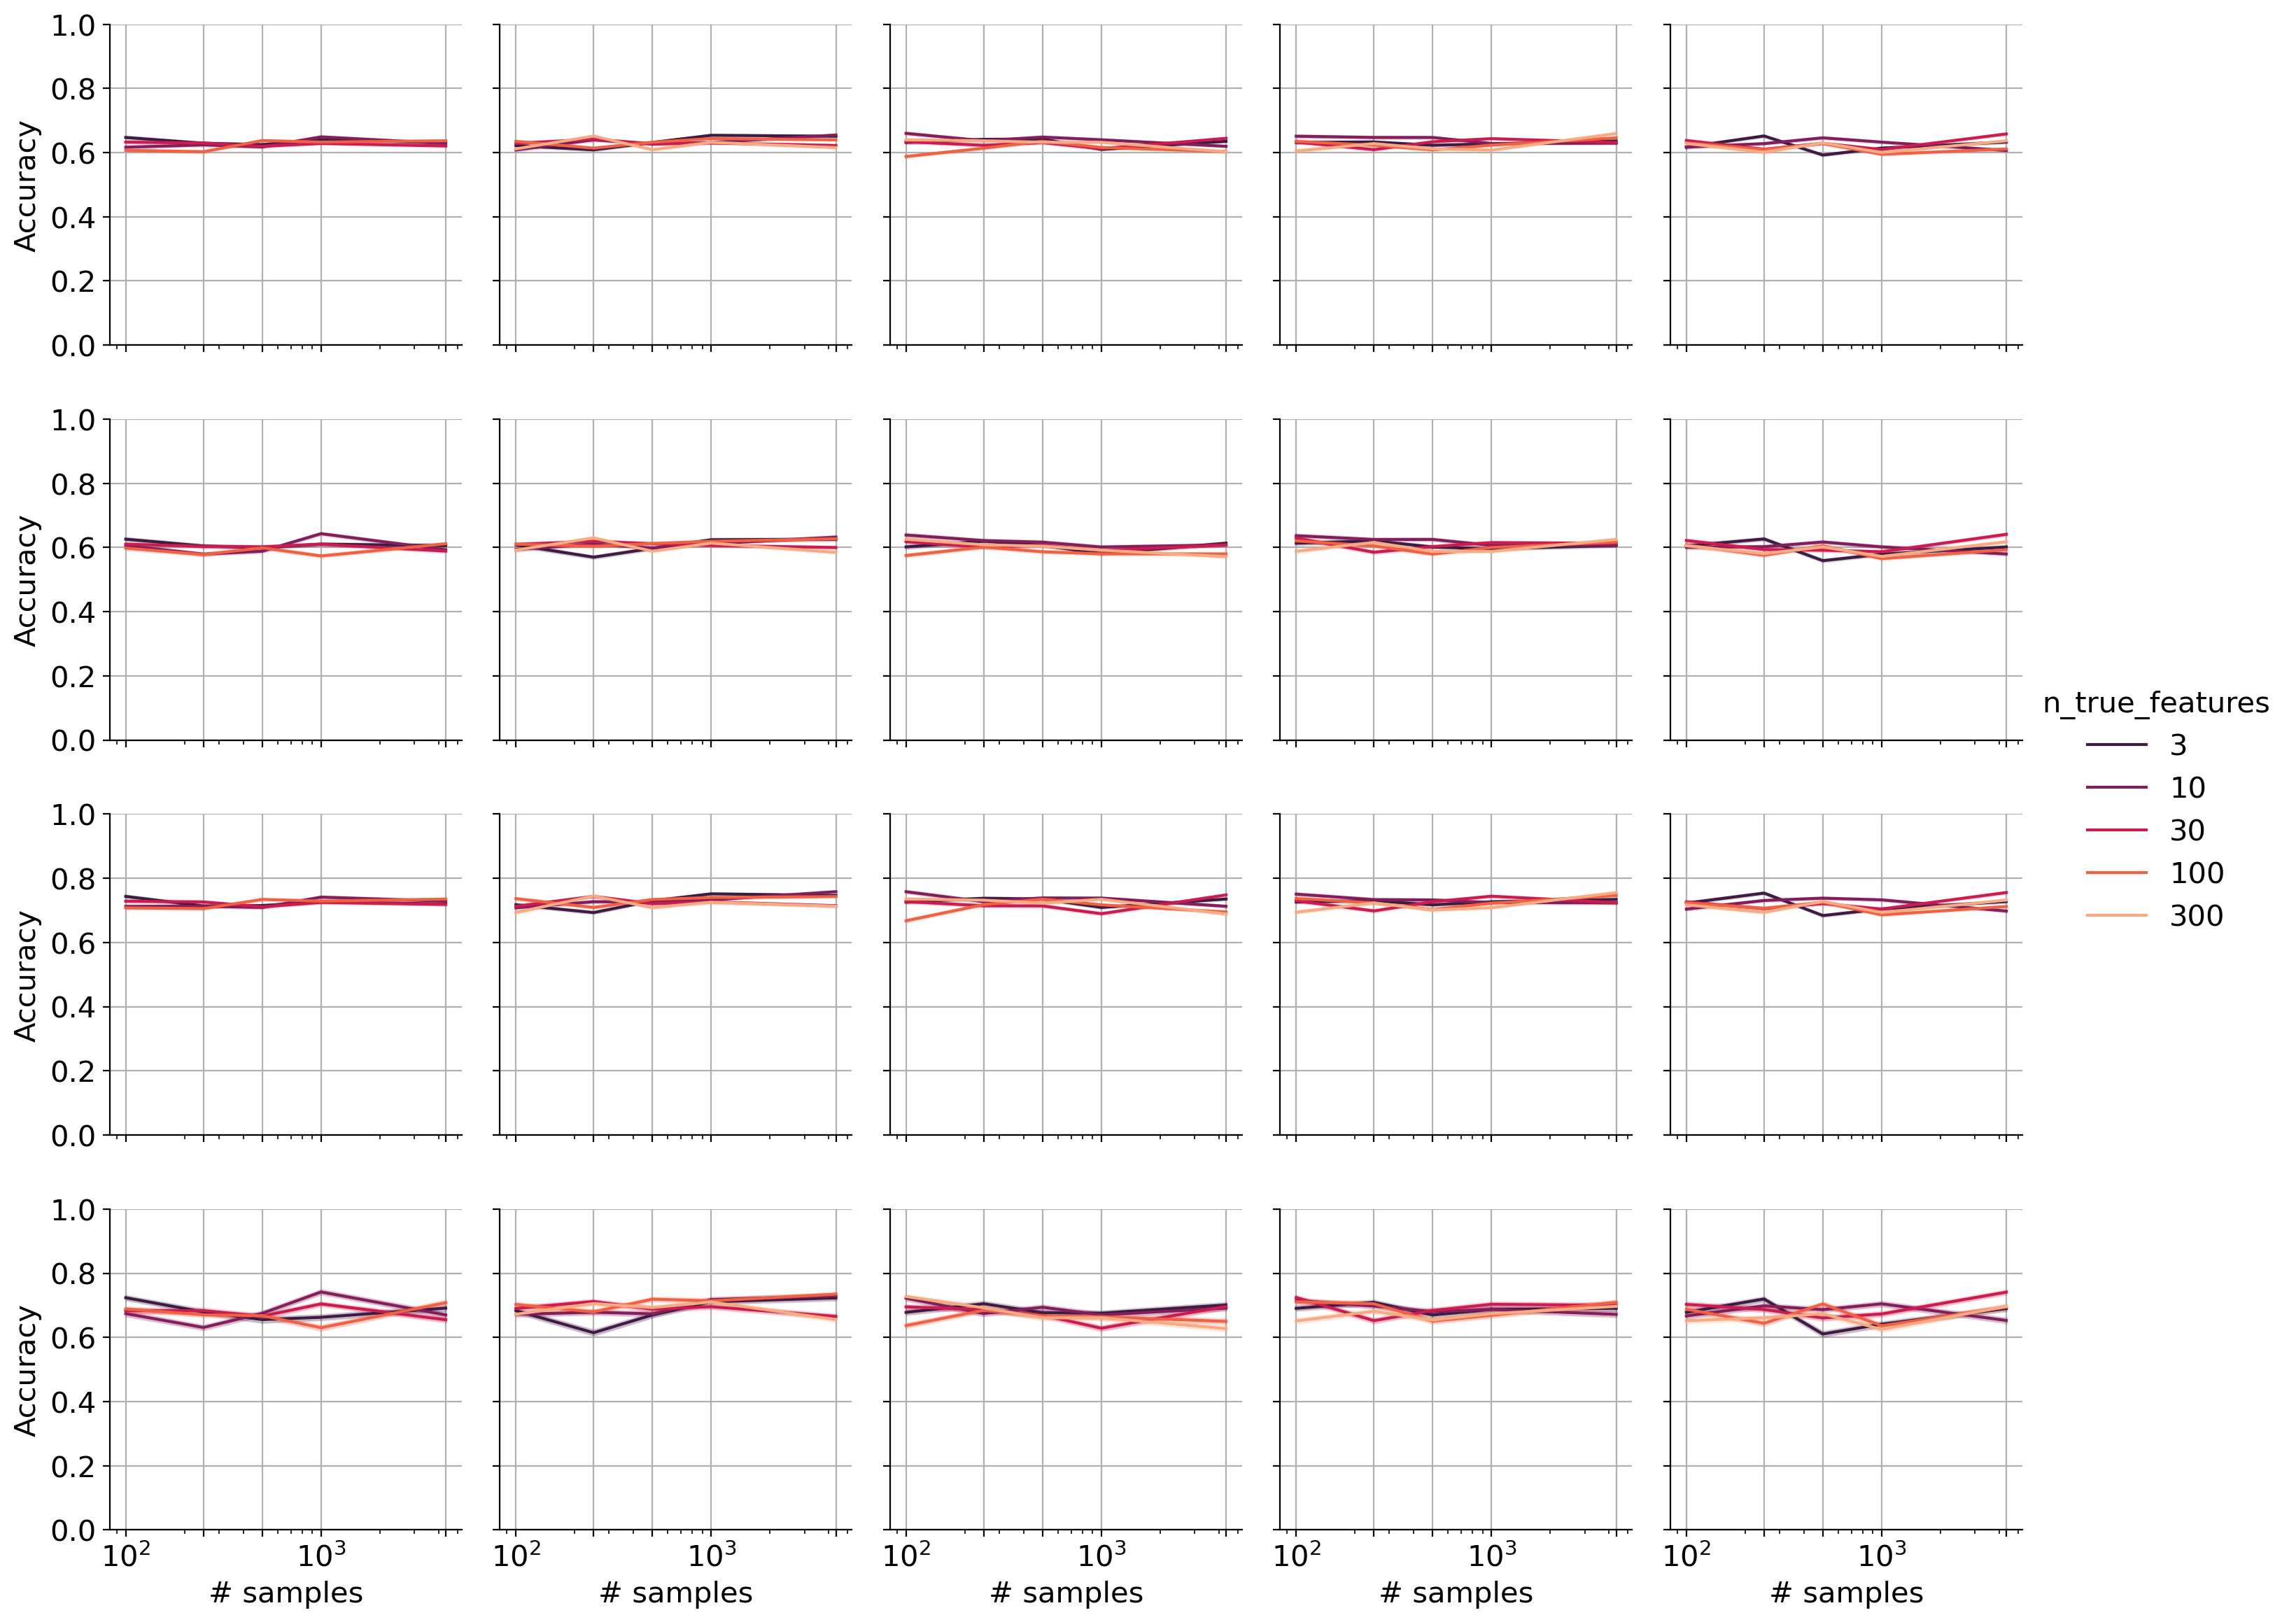

In [17]:
g=sns.relplot(data=null,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',row='model',
    height=3, aspect=1
    )
g.set_titles('')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0,1),xticks=null['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()

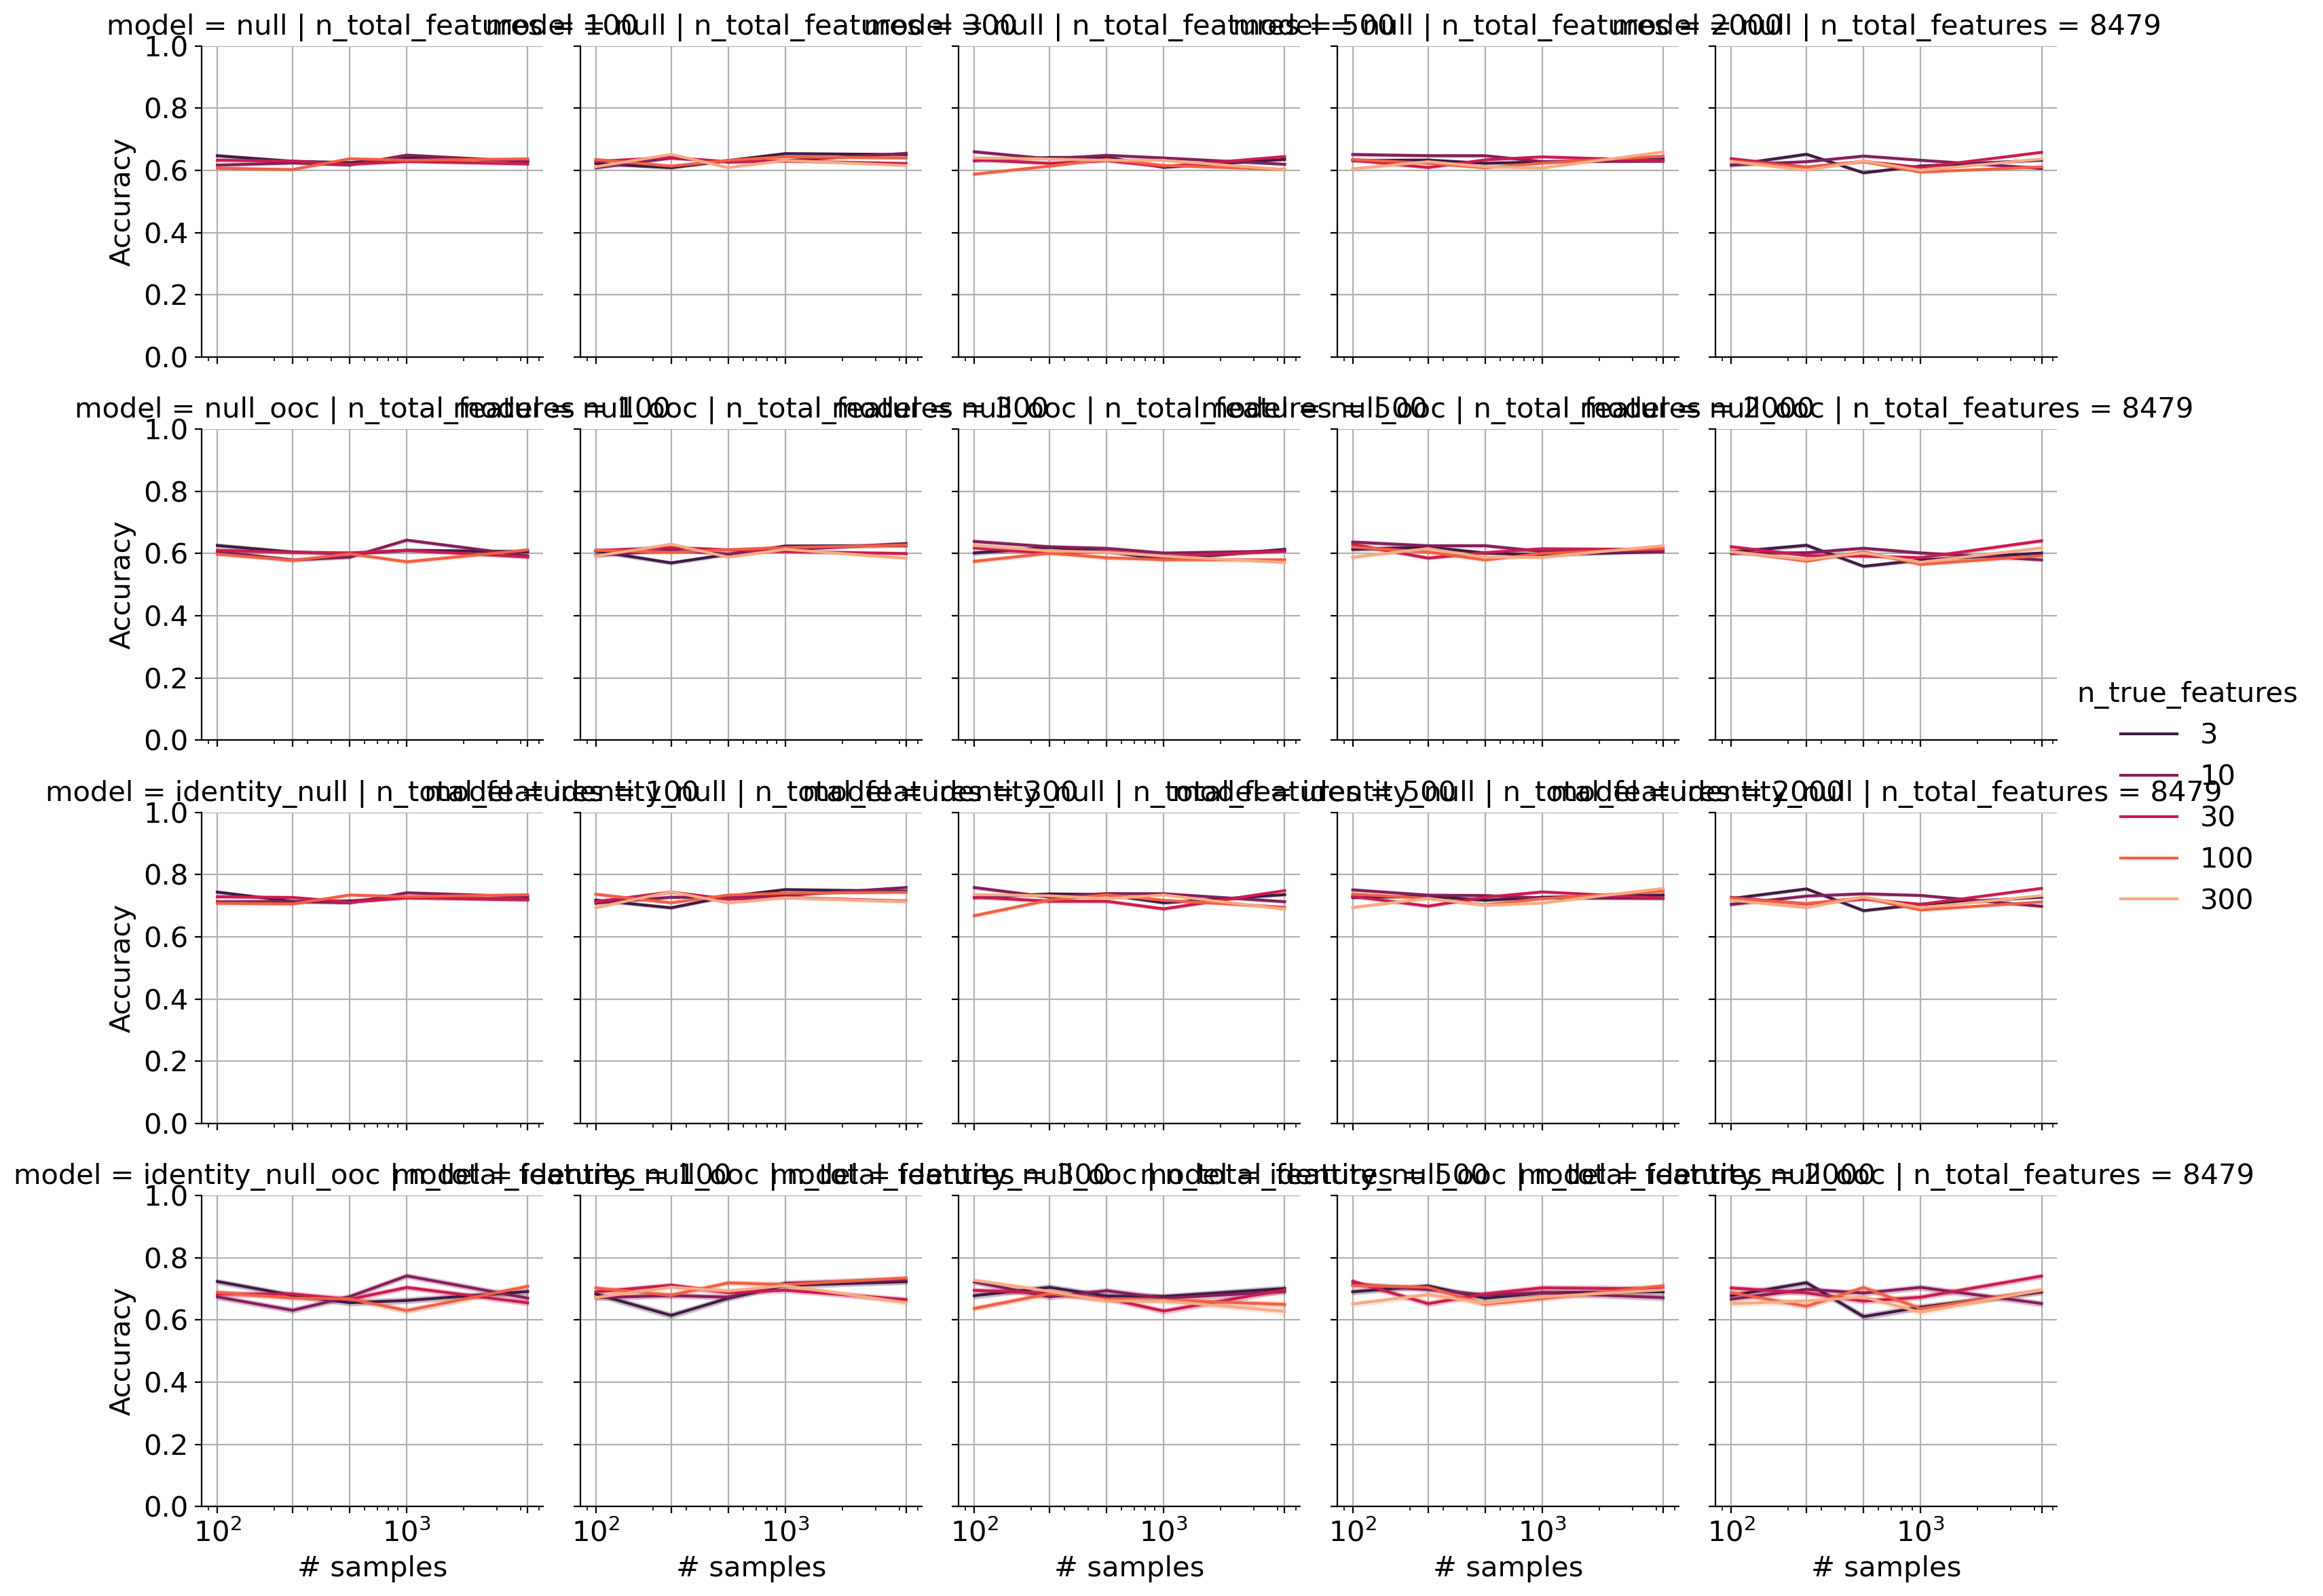

In [18]:
g=sns.relplot(data=null,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',row='model',
    height=3, aspect=1
    )
#g.set_titles('')
g.set_axis_labels('# samples', 'Accuracy')
g.set(xscale='log',ylim=(0,1),xticks=null['n_samples'].unique())

for ax in plt.gcf().get_axes():
    ax.grid()